# Titanic kaggle competition with SVM - Advanced

In [1]:
#import all the needed package
import numpy as np
import scipy as sp
import re
import pandas as pd
import sklearn
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn import metrics
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/chelsea/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Let's generate some more advanced features with the name column

In [21]:
#let's start to process the data first
data = pd.read_csv('data/train.csv')
# our target is the survived column
y= data['Survived']
#add in Sex_male features
data['Sex_male']=data.Sex.map({'female':0,'male':1})
#fill in Age data with the mean value
data['Age'][pd.isnull(data['Age'])]=data['Age'].mean()
#generate the title features
data['Title'] = data['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
        
# Group low-occuring, related titles together
data['Title'][data.Title == 'Jonkheer'] = 'Master'
data['Title'][data.Title.isin(['Ms','Mlle'])] = 'Miss'
data['Title'][data.Title == 'Mme'] = 'Mrs'
data['Title'][data.Title.isin(['Capt', 'Don', 'Major', 'Col', 'Sir'])] = 'Sir'
data['Title'][data.Title.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'
        
# Build binary features
data = pd.concat([data, pd.get_dummies(data['Title']).rename(columns=lambda x: 'Title_' + str(x))], axis=1)


data.head()

/Users/chelsea/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chelsea/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chelsea/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chelsea/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is try

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_male,Title,Title_Dr,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_Sir
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,1,Mr,0,0,0,0,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,...,0,Mrs,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,...,0,Miss,0,0,0,1,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,...,0,Mrs,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,1,Mr,0,0,0,0,1,0,0,0


Select the features from data, and do feature rescaling

In [22]:
#use our new features.
feature_cols=['Pclass','Age','SibSp','Parch','Fare','Sex_male','Title_Dr','Title_Lady','Title_Master','Title_Miss','Title_Mr','Title_Mrs','Title_Rev','Title_Sir']
X=data[feature_cols]
#feature rescaling, this is critical
X['Age']=(X['Age']-X['Age'].median())/X['Age'].std()
X['Fare']=(X['Fare']-X['Age'].median())/X['Age'].std()

/Users/chelsea/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chelsea/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We want to perform algorithm tuning with **CV** now, to avoid information leak, let's create a hold out set

In [23]:
#create a holdout set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

Below is a simple example of algorithm tuning with the rbf kernel of SVM. Of course, in real life you should perform parameter grid search in both **C** and **gamma**. 

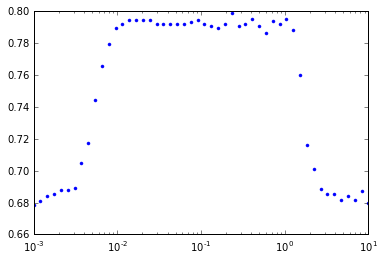

In [24]:
#tune the gamma parameter with our training set
scores_mean=[]
scores_std=[]
model=SVC()
model.C=1
gammas=np.logspace(-3,1,50)
for gamma in gammas:
    model.gamma=gamma
    scores=cross_val_score(model,X_train,y_train,cv=10,scoring='accuracy')
    scores_mean.append(np.mean(scores))
    scores_std.append(np.std(scores))
plt.semilogx(gammas,scores_mean,'.')
plt.show()


It seems that gamma is good in a broad range, Let's just take the middle of the flat part.

In [25]:
model.gamma=0.1
model.fit(X_train,y_train)
y_predta=model.predict(X_train)
y_pred=model.predict(X_test)
train_score=metrics.accuracy_score(y_train,y_predta)
test_score=metrics.accuracy_score(y_test,y_pred)
print train_score,test_score,cvscore,cvscore_std
scores=cross_val_score(model,X,y,cv=10,scoring='accuracy')
cvscore=np.mean(scores)
cvscore_std=np.std(scores)

0.845505617978 0.810055865922 0.795813471797 0.020976241339


### Are we nessary perform better than the simpler model? 

The real test is to submit the file to kaggle and let their hold out set decide.
I did improve my result by ~0.03 with the newly added in name features. 